# Worldchain User Model

- Get data via Pyoso --> [here](https://docs.opensource.observer/docs/get-started/python)
- Get raw data via BigQuery --> [here](https://docs.opensource.observer/docs/integrate/datasets/#superchain)
- View OSO staging model definitions --> [here](https://github.com/opensource-observer/oso/tree/main/warehouse/oso_sqlmesh/models/staging/superchain)

In [1]:
# ! pip install pyoso

In [2]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

In [3]:
df = client.to_pandas("""
SELECT
  DATE_TRUNC('day', first_verified_at) AS date,
  APPROX_DISTINCT(verified_address) AS users
FROM int_worldchain_verified_addresses
WHERE verified_until >= DATE '2025-03-01'
GROUP BY 1
ORDER BY 1
""")

df['date'] = pd.to_datetime(df['date'])
df['cumulative_users'] = df['users'].cumsum()
df.tail()

,date,users,cumulative_users
229,2025-04-17,16694,8889520
230,2025-04-18,17184,8906704
231,2025-04-19,16758,8923462
232,2025-04-20,16407,8939869
233,2025-04-21,17140,8957009


In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

def line_chart(dataframe, x, y, title, xtitle=None, millions=False):
    fig, ax = plt.subplots(figsize=(10, 5), facecolor='#fafafa')
    ax.set_facecolor('#fafafa')
    ax.plot(dataframe[x], dataframe[y], linewidth=3, color='#D62728')
    ax.set_title(title, loc='left', fontsize=16, pad=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.grid(False)
    plt.xticks(rotation=0, ha='center')
    if xtitle:
        ax.set_xlabel(xtitle, loc='left')

    if millions:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x*1e-6:.0f}M"))
    ax.set_ylim(0,)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

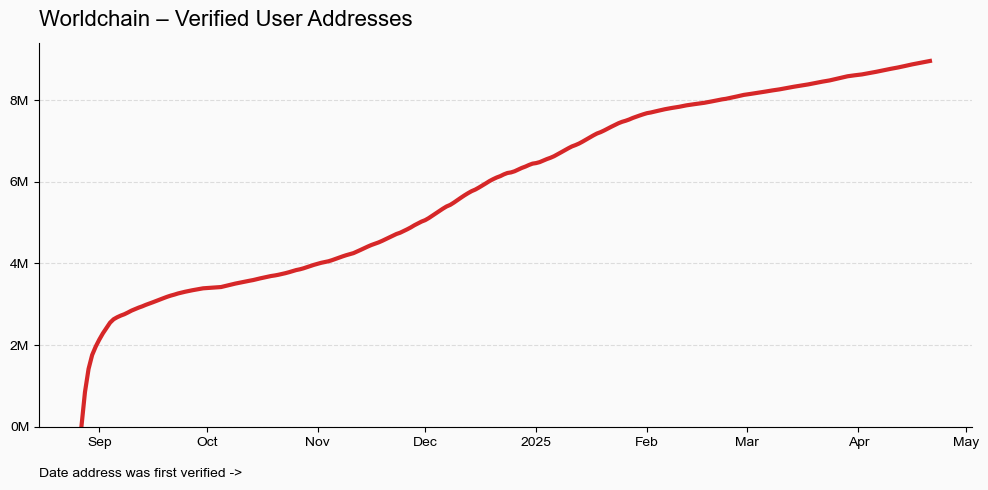

In [84]:
line_chart(
    df,
    x='date',
    y='cumulative_users',
    title='Worldchain – Verified User Addresses',
    millions=True,
    xtitle='\nDate address was first verified ->'
)

In [6]:
client.to_pandas("""
SELECT
    e.time,
    e.from_artifact_id AS user_id,
    p.display_name
FROM int_worldchain_events_by_project AS e
JOIN projects_v1 AS p ON e.project_id = p.project_id
WHERE e.event_type = 'WORLDCHAIN_VERIFIED_USEROP'
LIMIT 5
""")

,time,user_id,display_name
0,2025-04-19 02:37:59.000,VtPqaIsMH1sykSqS2v2rz8ueMHrvHKmdE7SPZFyFe10=,World Billboard
1,2025-04-19 05:18:19.000,PzR1MQ+ybcYb2sUnIvf5v8KPb3Cacs7xAda+u1Nrq0c=,World Billboard
2,2025-04-19 15:32:01.000,au5BEZb0cDWdJt9vHblJ0BImrE2FMGX88s6nEKOnX1c=,World Billboard
3,2025-04-19 03:16:07.000,dtjbbowt5TAUGyfTxjAxhJm3p5I6WgNxnoVzXf8lDEw=,World Billboard
4,2025-04-19 07:05:51.000,KuenEZTqCyCkh4BabVNDDxUXV6LDKLr2z7oX61lgKQM=,World Billboard


## Retention Query

In [ ]:
df_retention = client.to_pandas("""
    WITH base_events AS (                 -- 1️⃣ raw events, day-level
    SELECT
        DATE_TRUNC('day', e.time) AS event_date,
        e.from_artifact_id        AS user_id,
        e.project_id,
        p.display_name            AS project_name
    FROM int_worldchain_events_by_project e
    JOIN projects_v1               p ON p.project_id = e.project_id
    WHERE e.event_type = 'WORLDCHAIN_VERIFIED_USEROP'
),

first_touch AS (                     -- 2️⃣ first event per user+project
    SELECT
        user_id,
        project_id,
        MIN(event_date) AS cohort_date
    FROM base_events
    GROUP BY 1,2
),

/* 🔧 FIXED SECTION ───────────────────────────────────────────────────────── */
retention_flags AS (                 -- 3️⃣ flag users who return in windows
    SELECT
        t.project_id,
        t.cohort_date,
        t.user_id,
        MAX(CASE WHEN t.days_between BETWEEN 30 AND 59 THEN 1 END) AS retained_30d,
        MAX(CASE WHEN t.days_between BETWEEN 60 AND 89 THEN 1 END) AS retained_60d,
        MAX(CASE WHEN t.days_between >= 90           THEN 1 END) AS retained_90d
    FROM (
        SELECT
            be.project_id,
            ft.cohort_date,
            ft.user_id,
            DATE_DIFF('day', ft.cohort_date, be.event_date) AS days_between
        FROM first_touch ft
        JOIN base_events be
          ON be.user_id    = ft.user_id
         AND be.project_id = ft.project_id
    ) AS t
    GROUP BY 1,2,3
),
/* ─────────────────────────────────────────────────────────────────────────── */

project_retention AS (               -- 4️⃣ aggregate to cohort level
    SELECT
        p.display_name                            AS project_name,
        ft.cohort_date,
        COUNT(DISTINCT ft.user_id)                                AS users_in_cohort,
        COUNT(DISTINCT CASE WHEN rf.retained_30d = 1 THEN ft.user_id END) AS users_retained_30d,
        COUNT(DISTINCT CASE WHEN rf.retained_60d = 1 THEN ft.user_id END) AS users_retained_60d,
        COUNT(DISTINCT CASE WHEN rf.retained_90d = 1 THEN ft.user_id END) AS users_retained_90d
    FROM first_touch      ft
    JOIN projects_v1      p  ON p.project_id = ft.project_id
    LEFT JOIN retention_flags rf
           ON rf.user_id     = ft.user_id
          AND rf.project_id  = ft.project_id
          AND rf.cohort_date = ft.cohort_date
    GROUP BY 1,2
)

SELECT
    project_name,
    cohort_date,
    users_in_cohort,
    users_retained_30d,
    ROUND(100.0 * users_retained_30d / users_in_cohort, 2) AS pct_retained_30d,
    users_retained_60d,
    ROUND(100.0 * users_retained_60d / users_in_cohort, 2) AS pct_retained_60d,
    users_retained_90d,
    ROUND(100.0 * users_retained_90d / users_in_cohort, 2) AS pct_retained_90d
FROM project_retention
ORDER BY project_name, cohort_date
""")

## Show retention

In [61]:
list(df_retention['project_name'].unique())

['DNA Token',
 'Eat The Pie',
 'Eggs Vault',
 'Golden Otter',
 'Golden Otter Hub',
 'Got Vision',
 'HumanFi',
 'InfoFinance',
 'Magnify Cash World Mini App',
 'MemeWallet',
 'Morpho ',
 'ORB',
 'ORO',
 'O＝C＝O',
 'PUF',
 'PoolTogether',
 'Squadletics',
 'Superhero',
 'The Box',
 'The Button',
 'UNO',
 'Uniswap',
 'World Billboard',
 'WorldPot']

In [62]:
df_retention['cohort_date'] = pd.to_datetime(df_retention['cohort_date'])
df_retention['pct_retained_30d'] = pd.to_numeric(df_retention['pct_retained_30d'])
df_retention.tail()

,project_name,cohort_date,users_in_cohort,users_retained_30d,pct_retained_30d,users_retained_60d,pct_retained_60d,users_retained_90d,pct_retained_90d
2104,WorldPot,2025-04-17,1130,0,0.0,0,0.0,0,0.0
2105,WorldPot,2025-04-18,673,0,0.0,0,0.0,0,0.0
2106,WorldPot,2025-04-19,694,0,0.0,0,0.0,0,0.0
2107,WorldPot,2025-04-20,754,0,0.0,0,0.0,0,0.0
2108,WorldPot,2025-04-21,643,0,0.0,0,0.0,0,0.0


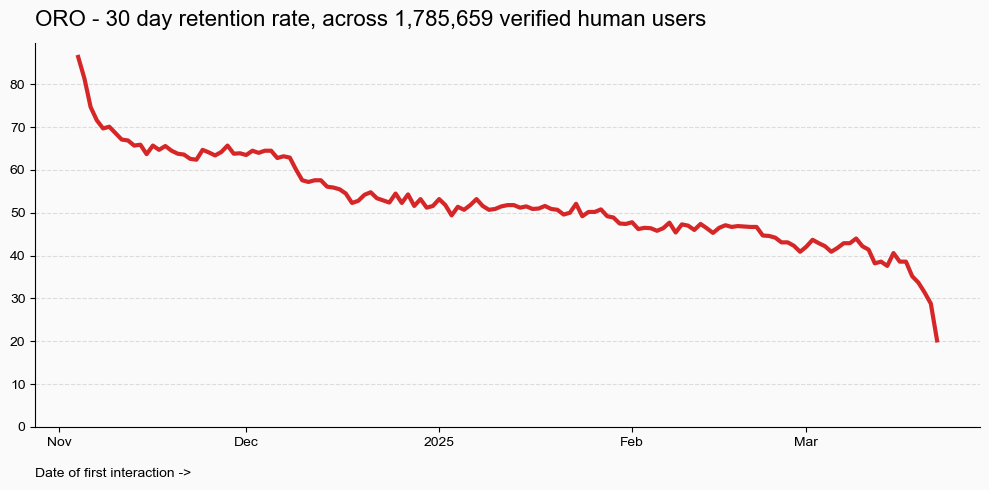

In [85]:
project = "ORO"   
df_ret = df_retention[df_retention['project_name'] == project]
num_users = df_ret['users_in_cohort'].sum()
line_chart(
    dataframe=df_ret[df_ret['pct_retained_30d']>0],
    x='cohort_date',
    y='pct_retained_30d',
    title=f"{project} - 30 day retention rate, across {num_users:,.0f} verified human users",
    xtitle='\nDate of first interaction ->'
)

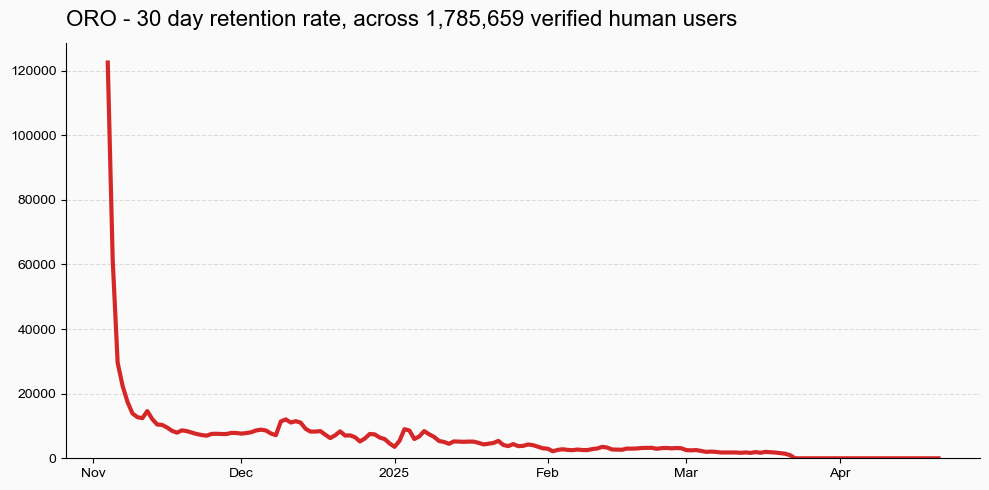

In [76]:
project = "ORO"   
df_ret = df_retention[df_retention['project_name'] == project]
num_users = df_ret['users_in_cohort'].sum()
line_chart(
    dataframe=df_ret,
    x='cohort_date',
    y='users_retained_30d',
    title=f"{project} - 30 day retention rate, across {num_users:,.0f} verified human users"
)

## Initial experimentation (deprecated)

In [3]:
TEST_CONTRACT = '0xcd1E32B86953D79a6AC58e813D2EA7a1790cAb63'.lower()

In [4]:
df_traces = client.to_pandas(f"""
    SELECT *
    FROM stg_superchain__traces
    WHERE
        chain = 'WORLDCHAIN'
        AND to_address = '{TEST_CONTRACT}'
        AND block_timestamp BETWEEN DATE '2025-03-29' and DATE '2025-03-30'
    LIMIT 5
""")
df_traces

,block_timestamp,transaction_hash,from_address,to_address,gas_used,chain
0,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0xe7155fbfe051f624091efbb050b19a36ece2e044,0xcd1e32b86953d79a6ac58e813d2ea7a1790cab63,229871,WORLDCHAIN
1,2025-03-29 18:23:45.000,0xaeedc08c15c43d638bcbf5c15a26f7c7739e0e969906...,0xfd7539c735f0e415cad6c5a81a3973d07eb30533,0xcd1e32b86953d79a6ac58e813d2ea7a1790cab63,229871,WORLDCHAIN
2,2025-03-29 02:40:21.000,0x762d0aa92b99823c0b61328f122b82e485e892f43ae9...,0xaeabb822aa345e4daeef75d015983ee1ace75cdb,0xcd1e32b86953d79a6ac58e813d2ea7a1790cab63,229871,WORLDCHAIN
3,2025-03-29 14:42:15.000,0x2ac72a868587388ea7d0708c3080b733406b9c2e6b64...,0x377d74d621852cd891071e55283608233d4d4fd7,0xcd1e32b86953d79a6ac58e813d2ea7a1790cab63,229871,WORLDCHAIN
4,2025-03-29 16:18:21.000,0xebebf1d6f1c94dc9eec033a52d613bf4543f52a4c514...,0x70854a3335c2dbdb85df592069e16a6f6f4750eb,0xcd1e32b86953d79a6ac58e813d2ea7a1790cab63,229871,WORLDCHAIN


In [5]:
TEST_HASH = df_traces['transaction_hash'].iloc[0]
TEST_HASH

'0xc1c70e8820e4f3752a7851c1d648205c969e3067889f66f1eb4e1fb2f1fb53fe'

In [6]:
df_4337_traces = client.to_pandas(f"""
    SELECT *
    FROM stg_superchain__4337_traces
    WHERE
        chain = 'WORLDCHAIN'
        AND transaction_hash = '{TEST_HASH}'
        AND block_timestamp BETWEEN DATE '2025-03-29' and DATE '2025-03-30'
""")
df_4337_traces

,chain,block_timestamp,transaction_hash,userop_hash,method_id,from_address,to_address,bundler_address,paymaster_address,userop_gas_price,userop_gas_used,value
0,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x7dfe723d87f76d88dea1eadd3993ab7ae9e668dd7026...,0x7bb37428,0xdd4ed10d254efbdd098fd8dd861674dfbff0bbc7,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,70623294170,579535,0.000000000000000000
1,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x8312c204fdeecc4cfc63eabf5e95b5eeee651a5ac026...,0x7bb37428,0xfbfb53b9004ccdeff587991001c30e849f58bf98,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,125308257360,1028280,0.000000000000000000
2,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x53e5489b14f0b62cc1977080996ea67fe2cbb2a9675e...,0x7bb37428,0x5f6d67673e7e03595862fe170b9c5b70e50a9460,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,59367266816,487168,0.000000000000000000
3,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x12a5bf995005c9b5a94c5bd0fcc4226e2c60ab2a38ed...,0x7bb37428,0x0a1dbd943db11ea51d8b944936b20a17c5ab6567,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,72433188594,594387,0.000000000000000000
4,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0xd953333376b5d60ae787b350494e72241bde7f8a237c...,0x7bb37428,0x30e04472766a96a4fe18483945871d5b0deebd68,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,118053446914,968747,0.000000000000000000
5,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0xa3f342d5dbb1e332e5f282eca7ae3c2e867fff623b4a...,0x7bb37428,0x8ca7cb5580205bca17d42c7f2b4970d1baf6a804,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,119700411844,982262,0.000000000000000000
6,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0xde9ffc70a8fcf92c46d0a149a34fd7cf3eca93f95581...,0x7bb37428,0xba97c26102db594ec885b283e7772e997115e536,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,70105380670,575285,0.000000000000000000
7,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x75d49e1b6ae58184178da056464f3fac1e3a9ac3834a...,0x7bb37428,0x4e8ab9d3e2a290b565bc77c2287c6d68e5479901,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,69148154660,567430,0.000000000000000000
8,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x0c8fb54404844f6db1d6de1392f98b73da0ca6fa1dda...,0x7bb37428,0xa8b0fe5b6126e31f9761238c0c9cf42d05e7d575,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,77491436490,635895,0.000000000000000000
9,WORLDCHAIN,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,0x1325fd65c67a06b39890f65cc0e2d4760872cbc7d19d...,0x7bb37428,0xe7155fbfe051f624091efbb050b19a36ece2e044,0x75cf11467937ce3f2f357ce24ffc3dbf8fd5c226,0x8f47a238c7701247ee8469ddc37ac1df121cfcce,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,125301433088,1028224,0.000000000000000000


In [7]:
df_4337_logs = client.to_pandas(f"""
    SELECT *
    FROM stg_superchain__4337_userop_logs
    WHERE
        chain = 'WORLDCHAIN'
        AND transaction_hash = '{TEST_HASH}'
        AND block_timestamp BETWEEN DATE '2025-03-29' and DATE '2025-03-30'
""")
df_4337_logs

,block_timestamp,transaction_hash,log_index,userop_hash,sender_address,paymaster_address,contract_address,userop_gas_price,userop_gas_used,chain
0,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,222,0x75d49e1b6ae58184178da056464f3fac1e3a9ac3834a...,0x4e8ab9d3e2a290b565bc77c2287c6d68e5479901,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,69148154660,567430,WORLDCHAIN
1,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,269,0x7dfe723d87f76d88dea1eadd3993ab7ae9e668dd7026...,0xdd4ed10d254efbdd098fd8dd861674dfbff0bbc7,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,70623294170,579535,WORLDCHAIN
2,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,265,0x12a5bf995005c9b5a94c5bd0fcc4226e2c60ab2a38ed...,0x0a1dbd943db11ea51d8b944936b20a17c5ab6567,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,72433188594,594387,WORLDCHAIN
3,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,240,0x53e5489b14f0b62cc1977080996ea67fe2cbb2a9675e...,0x5f6d67673e7e03595862fe170b9c5b70e50a9460,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,59367266816,487168,WORLDCHAIN
4,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,260,0xa1bc8a974bad49b4cbef1f7a05a29b56d4cf0375056f...,0x0d012028073a568c4836077265a14902aacefa14,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,74132676046,608333,WORLDCHAIN
5,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,231,0x52402b78d1e309c5c7a11b05afec02efb7e240d56494...,0x93b993556f4680be0ddf44e16d8acb47e55c69d9,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,64003262882,525211,WORLDCHAIN
6,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,250,0x8312c204fdeecc4cfc63eabf5e95b5eeee651a5ac026...,0xfbfb53b9004ccdeff587991001c30e849f58bf98,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,125308257360,1028280,WORLDCHAIN
7,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,236,0xd953333376b5d60ae787b350494e72241bde7f8a237c...,0x30e04472766a96a4fe18483945871d5b0deebd68,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,118053446914,968747,WORLDCHAIN
8,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,255,0x1325fd65c67a06b39890f65cc0e2d4760872cbc7d19d...,0xe7155fbfe051f624091efbb050b19a36ece2e044,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,125301433088,1028224,WORLDCHAIN
9,2025-03-29 13:39:05.000,0xc1c70e8820e4f3752a7851c1d648205c969e3067889f...,245,0xde9ffc70a8fcf92c46d0a149a34fd7cf3eca93f95581...,0xba97c26102db594ec885b283e7772e997115e536,0xef725aa22d43ea69fb22be2ebe6eca205a6bcf5b,0x0000000071727de22e5e9d8baf0edac6f37da032,70105380670,575285,WORLDCHAIN
